## SBrT 2024 - **An Introduction to Generative Artificial Intelligence with Applications in Telecommunications**


## Implementation of Variational AutoEncoder (VAE)

### This python notebook was based on the code at https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb, and at https://github.com/nyu-wireless/mmwchanmod/tree/master that comes from the paper called: [Generative Neural Network Channel Modeling for Millimeter-Wave UAV Communication](https://ieeexplore.ieee.org/document/9782737)    .


The objective of this notebook is show how to construct a basic VAE model in python and how this model can be adapted to be used with wireless channels

In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  171.64761086185308
	Epoch 2 complete! 	Average Loss:  128.02016277128547
	Epoch 3 complete! 	Average Loss:  116.16337792805717
	Epoch 4 complete! 	Average Loss:  112.08026716076273
	Epoch 5 complete! 	Average Loss:  109.95058089980697
	Epoch 6 complete! 	Average Loss:  108.51710208746348
	Epoch 7 complete! 	Average Loss:  107.46951119704717
	Epoch 8 complete! 	Average Loss:  106.45664005438752
	Epoch 9 complete! 	Average Loss:  105.6338343202212
	Epoch 10 complete! 	Average Loss:  105.0176470875939
	Epoch 11 complete! 	Average Loss:  104.43972056291736
	Epoch 12 complete! 	Average Loss:  103.9388274076586
	Epoch 13 complete! 	Average Loss:  103.48099906093489
	Epoch 14 complete! 	Average Loss:  103.07629804557074
	Epoch 15 complete! 	Average Loss:  102.74811846241131
	Epoch 16 complete! 	Average Loss:  102.5166898117957
	Epoch 17 complete! 	Average Loss:  102.24929182100375
	Epoch 18 complete! 	Average Loss:  102.0251552881104
	E

### Step 5. Generate images from test dataset

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

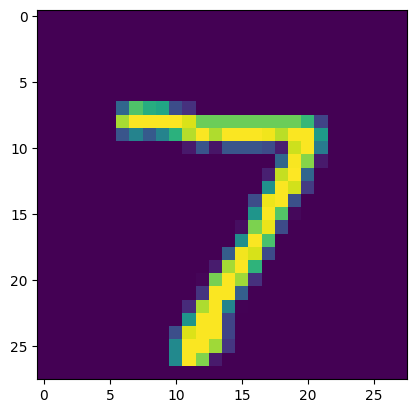

In [ ]:
show_image(x, idx=0)

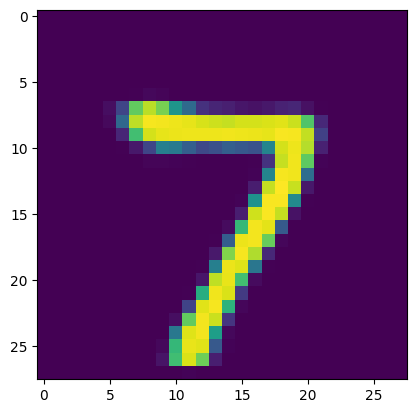

In [ ]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [ ]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

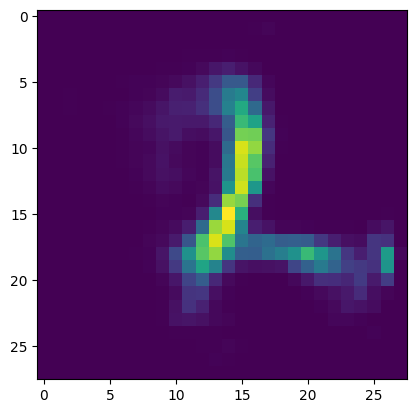

In [ ]:
show_image(generated_images, idx=12)

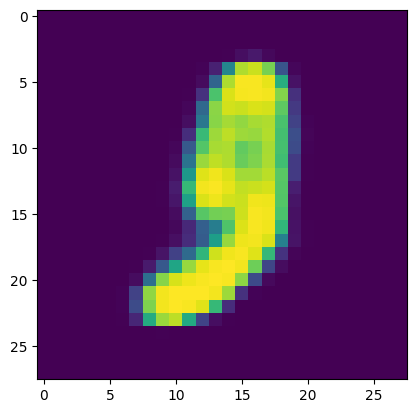

In [ ]:
show_image(generated_images, idx=0)

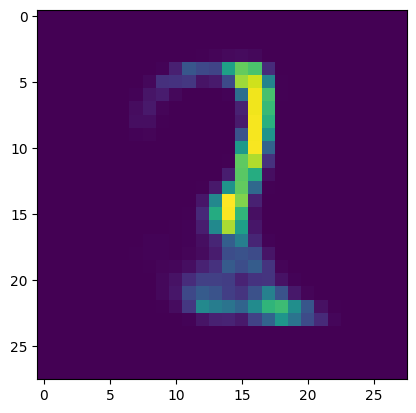

In [ ]:
show_image(generated_images, idx=1)

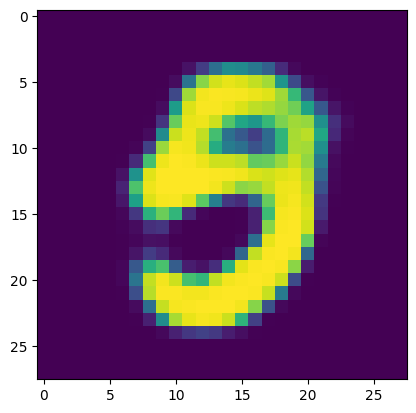

In [ ]:
show_image(generated_images, idx=10)

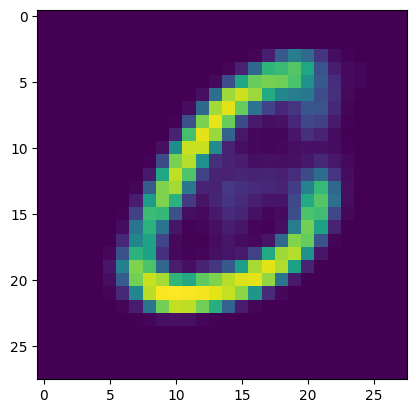

In [ ]:
show_image(generated_images, idx=20)

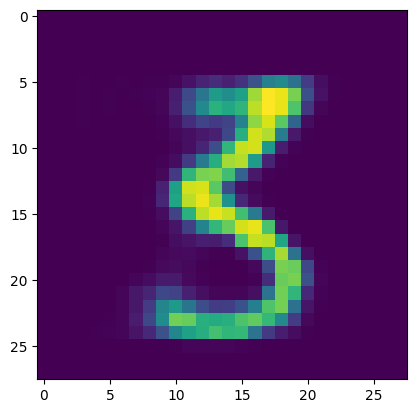

In [ ]:
show_image(generated_images, idx=50)

### Generative Neural Network Channel Modeling for Millimeter-Wave UAV Communication

In [ ]:
    def build_encoder(self):
        """
        Builds the encoder network

        The encoder maps [x,cond] to [z_mu, z_log_var]
        """
        x = tfkl.Input((self.ndat,), name='x')
        cond = tfkl.Input((self.ncond,), name='cond')

        dat_cond = tfkl.Concatenate(name='dat_cond')([x, cond])



        # Add the hidden layers
        h = dat_cond
        layer_names = []
        for i in range(len(self.nunits_enc)):
            h = tfkl.Dense(self.nunits_enc[i], activation='sigmoid',\
                           name='FC%d' % i)(h)
            layer_names.append('FC%d' % i)

        # Add the final output layer
        z_mu = tfkl.Dense(self.nlatent, activation='linear',\
                          bias_initializer=None, name='z_mu')(h)
        z_log_var = tfkl.Dense(self.nlatent, activation='linear',\
                          bias_initializer=None, name='z_log_var')(h)

        # Save the encoder model
        self.encoder = tfkm.Model([x, cond],\
                                  [z_mu, z_log_var])

        # Set the initialization
        set_initialization(self.encoder, layer_names,\
                           self.init_kernel_stddev, self.init_bias_stddev)


In [ ]:
    def reparm(self, z_mu, z_log_var):
        """
        Re-parametrization layer

            z = z_mu + eps * tf.exp(z_log_var*0.5)

        where eps is unit Gaussian
        """
        batch_shape = tf.shape(z_mu)
        eps = tf.random.normal(shape=batch_shape)
        z = eps * tf.exp(z_log_var*0.5) + z_mu
        return z

In [ ]:
    def build_decoder(self):
        """
        Builds the decoder network.
        The decoder network is the generative model mapping:

            [z,cond] to xhat

        """
        # Input layer
        z_samp = tfkl.Input((self.nlatent,), name='z')
        cond = tfkl.Input((self.ncond,), name='cond')
        z_cond = tfkl.Concatenate(name='z_cond')([z_samp, cond])

        # Hidden layers
        layer_names = []
        h = z_cond
        for i in range(len(self.nunits_enc)):
            h = tfkl.Dense(self.nunits_enc[i], activation='sigmoid',\
                           bias_initializer=None, name='FC%d' % i)(h)
            layer_names.append('FC%d' % i)

        # Add the output mean
        x_mu = tfkl.Dense(self.ndat, name='x_mu',\
                          bias_initializer=None)(h)
        # Add sorting of the first path loss values
        if self.nsort > 0:
            x_mu_pl = x_mu[:,:self.nsort]
            x_mu_pl = tf.sort(x_mu_pl, direction='DESCENDING', axis=-1)
            x_mu_ang = x_mu[:,self.nsort:]
            x_mu = tfkl.Concatenate()([x_mu_pl, x_mu_ang])

        # Add the output variance.
        x_log_var = tfkl.Dense(self.ndat, name='x_log_var')(h)
        x_log_var = tf.maximum(x_log_var, np.log(self.out_var_min) )

        # Build the decoder
        self.decoder = tfkm.Model([z_samp, cond], [x_mu, x_log_var])

        # Set the initialization
        set_initialization(self.decoder, layer_names,\
                           self.init_kernel_stddev, self.init_bias_stddev)

        # Build the decoder with sampling
        x_samp = self.reparm(x_mu, x_log_var)
        self.sampler = tfkm.Model([z_samp, cond], x_samp)


In [ ]:
    def build_vae(self):
        """
        Builds the VAE to train.

        The VAE takes an input sample x and outputs [xhat,x_log_var].
        It also has the reconstruction and KL divergence loss

        """
        # Build the encoder and decoder
        self.build_encoder()
        self.build_decoder()

        # Inputs for the VAE
        x = tfkl.Input((self.ndat,), name='x')
        cond = tfkl.Input((self.ncond,), name='cond')

        # Encoder
        z_mu, z_log_var = self.encoder([x,cond])
        z_samp = self.reparm(z_mu, z_log_var)

        # Decoder
        xhat, x_log_var = self.decoder([z_samp, cond])
        self.vae = tfkm.Model([x, cond], [xhat, x_log_var])

        # Add reconstruction loss
        recon_loss = K.square(xhat - x)*tf.exp(-x_log_var) + x_log_var + \
            np.log(2*np.pi)
        recon_loss = 0.5*K.sum(recon_loss, axis=-1)

        # Add the KL divergence loss
        kl_loss = 1 + z_log_var - K.square(z_mu) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(recon_loss + kl_loss)
        self.vae.add_loss(vae_loss)

In [ ]:
   def build_path_mod(self):
        """
        Builds the VAE for the NLOS paths
        """

        # Number of data inputs in the transformed domain
        # For each sample and each path, there is:
        # * one path loss value
        # * nangle angles
        # * one delay
        # for a total of (2+nangle)*npaths_max parameters
        self.ndat = self.npaths_max*(2+AngleFormat.nangle)

        # Number of condition variables
        #   * d3d
        #   * log10(d3d)
        #   * dvert
        #   * los
        #   * rx_type  one-hot encoded dropping final type
        self.ncond = 4 + len(self.rx_types)-1